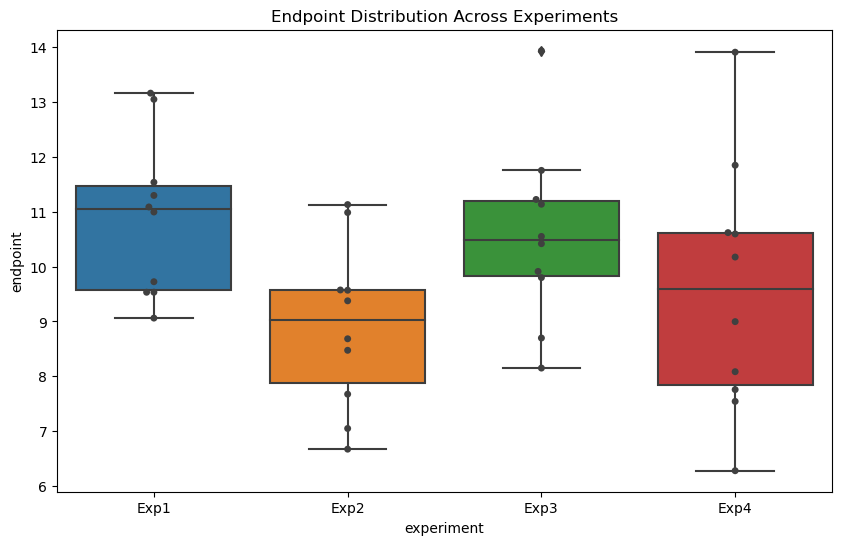

Levene’s Test: p = 0.3328
Fligner-Killeen Test: p = 0.3727

ANOVA Results:
                   sum_sq    df         F    PR(>F)
C(experiment)   24.577410   3.0  2.670951  0.062027
Residual       110.420947  36.0       NaN       NaN

Linear Mixed-Effects Model Summary:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: endpoint
No. Observations: 40      Method:             REML    
No. Groups:       4       Scale:              3.0672  
Min. group size:  10      Log-Likelihood:     -80.5119
Max. group size:  10      Converged:          Yes     
Mean group size:  10.0                                
------------------------------------------------------
             Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    9.988    0.453 22.069 0.000  9.101 10.875
Group Var    0.513    0.398                           


Likelihood Ratio Test comparing null vs LMEM:
LR stat = 1.147, p = 0.2843


C:\Users\keebs\Anaconda\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


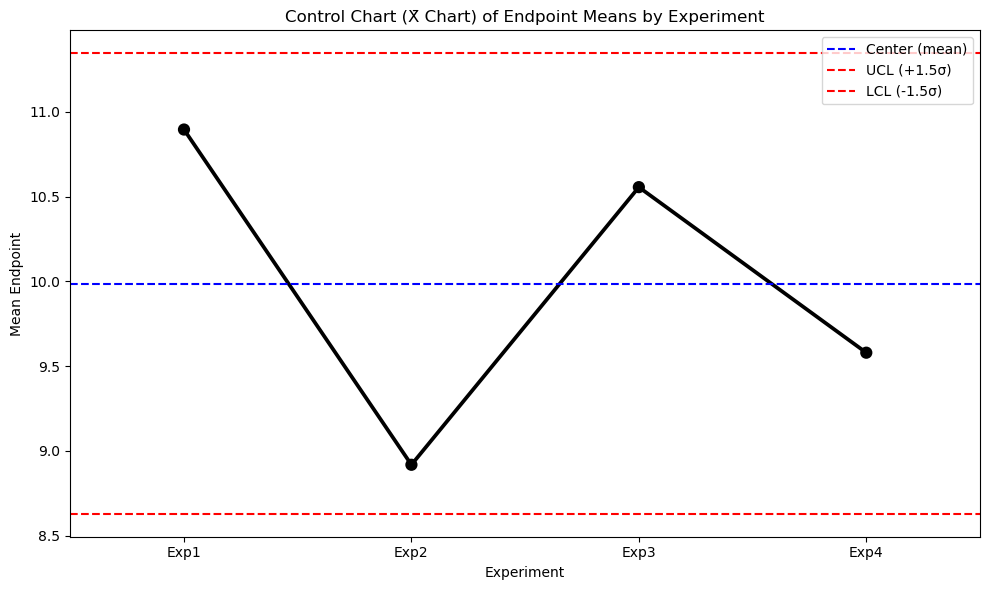

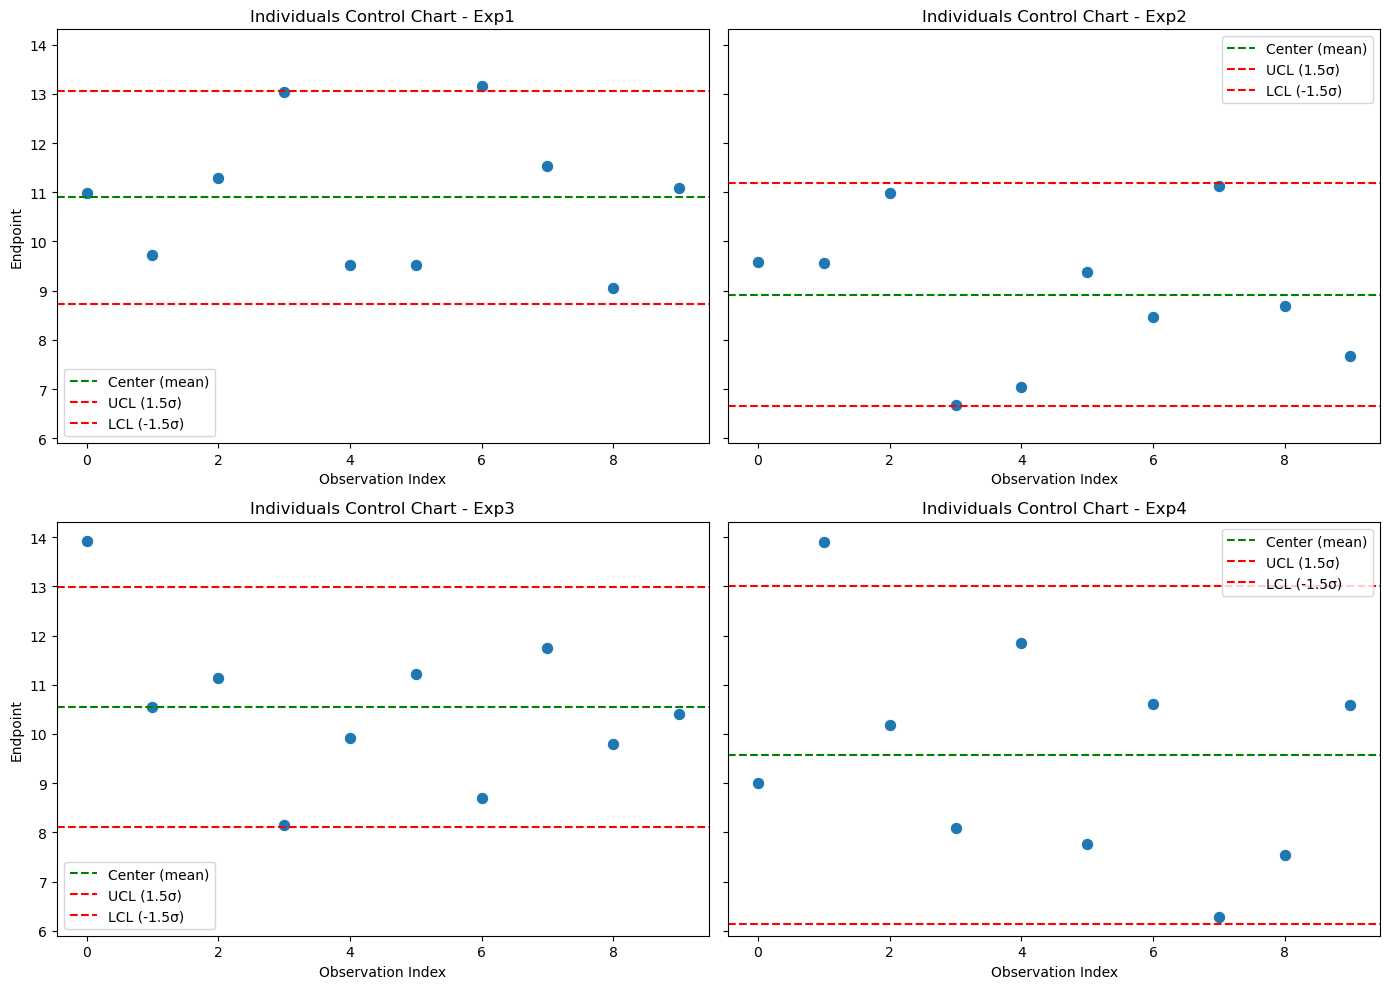

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene, fligner, chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm

# === 1. LOAD DATA ===
# Replace this with your actual data file or DataFrame
# Simulate example data
np.random.seed(42)
data = pd.DataFrame({
    'experiment': np.repeat(['Exp1', 'Exp2', 'Exp3', 'Exp4'], 10),
    'endpoint': np.concatenate([
        np.random.normal(10, 2, 10),
        np.random.normal(10.5, 2, 10),
        np.random.normal(11, 2, 10),
        np.random.normal(10.2, 2, 10),
    ])
})

# === 2. VISUALIZATION ===
plt.figure(figsize=(10, 6))
sns.boxplot(x='experiment', y='endpoint', data=data)
sns.swarmplot(x='experiment', y='endpoint', data=data, color=".25")
plt.title("Endpoint Distribution Across Experiments")
plt.show()

# === 3. VARIANCE HOMOGENEITY TESTS ===
groups = [group["endpoint"].values for name, group in data.groupby("experiment")]
stat_levene, p_levene = levene(*groups)
stat_fligner, p_fligner = fligner(*groups)

print(f"Levene’s Test: p = {p_levene:.4f}")
print(f"Fligner-Killeen Test: p = {p_fligner:.4f}")

# === 4. ANOVA ===
model_aov = ols('endpoint ~ C(experiment)', data=data).fit()
anova_table = sm.stats.anova_lm(model_aov, typ=2)
print("\nANOVA Results:")
print(anova_table)

# === 5. LINEAR MIXED EFFECTS MODEL ===
# Null model (no random effects)
model_null = ols("endpoint ~ 1", data=data).fit()

# Mixed model with random intercept for experiment
model_lmem = mixedlm("endpoint ~ 1", data, groups=data["experiment"]).fit()

print("\nLinear Mixed-Effects Model Summary:")
print(model_lmem.summary())

# === 6. LIKELIHOOD RATIO TEST ===
LL_null = model_null.llf
LL_mixed = model_lmem.llf
LR_stat = 2 * (LL_mixed - LL_null)
p_value_LRT = chi2.sf(LR_stat, df=1)

print(f"\nLikelihood Ratio Test comparing null vs LMEM:")
print(f"LR stat = {LR_stat:.3f}, p = {p_value_LRT:.4f}")

# === 7. INTRA-CLASS CORRELATION (ICC) ===
var_between = model_lmem.cov_re.iloc[0, 0]
var_within = model_lmem.scale
icc = var_between / (var_between + var_within)

# === 8. CONTROL CHART (X-bar) ===
# Compute group means
means = data.groupby("experiment")["endpoint"].mean()
x_bar = means.mean()
s = means.std()

ucl = x_bar + 1.5 * s
lcl = x_bar - 1.5 * s

# Plot
plt.figure(figsize=(10, 6))
sns.pointplot(x=means.index, y=means.values, color='black')
plt.axhline(x_bar, color='blue', linestyle='--', label='Center (mean)')
plt.axhline(ucl, color='red', linestyle='--', label='UCL (+1.5σ)')
plt.axhline(lcl, color='red', linestyle='--', label='LCL (-1.5σ)')
plt.title("Control Chart (X̄ Chart) of Endpoint Means by Experiment")
plt.ylabel("Mean Endpoint")
plt.xlabel("Experiment")
plt.legend()
plt.tight_layout()
plt.show()

# === Optional: Individuals Control Chart ===
experiments = data['experiment'].unique()

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axs = axs.flatten()

for i, exp in enumerate(experiments):
    subset = data[data['experiment'] == exp].reset_index(drop=True)
    mean_exp = subset['endpoint'].mean()
    std_exp = subset['endpoint'].std()
    ucl_exp = mean_exp + 1.5 * std_exp
    lcl_exp = mean_exp - 1.5 * std_exp
    
    ax = axs[i]
    sns.scatterplot(x=subset.index, y=subset['endpoint'], ax=ax, s=80, color='tab:blue')
    ax.axhline(mean_exp, color='green', linestyle='--', label='Center (mean)')
    ax.axhline(ucl_exp, color='red', linestyle='--', label='UCL (1.5σ)')
    ax.axhline(lcl_exp, color='red', linestyle='--', label='LCL (-1.5σ)')
    ax.set_title(f"Individuals Control Chart - {exp}")
    ax.set_xlabel("Observation Index")
    ax.set_ylabel("Endpoint")
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
"""
Step-by-step analysis of experimental consistency across batches
using ANOVA, LMEM, variance tests, and control charts.
"""

# === 1. Variance Homogeneity Tests ===
if p_levene > 0.05 and p_fligner > 0.05:
    print("✅ Variance is approximately equal across experiments (homoscedastic).")
else:
    print("⚠️ Variance differs between experiments. ANOVA assumptions may be violated.")

# === 2. ANOVA Interpretation ===
if anova_table['PR(>F)'][0] < 0.05:
    print("❗ ANOVA indicates a statistically significant difference in means across experiments.")
else:
    print("✅ ANOVA does not detect statistically significant mean differences across experiments.")

# === 3. Linear Mixed-Effects Model ===
print(f"📊 LMEM Group Variance Estimate: {model_lmem.cov_re.iloc[0, 0]:.3f}")
print(f"📊 LMEM Residual Variance (Within): {model_lmem.scale:.3f}")

# === 4. Likelihood Ratio Test ===
if p_value_LRT < 0.05:
    print("❗ Random effect (experiment) is statistically significant — consider modeling this variation.")
else:
    print("✅ Random effect (experiment) is NOT statistically significant — experiments are consistent.")

# === 5. Intra-Class Correlation (ICC) ===
print(f"🔢 ICC: {icc:.3f}")
if icc < 0.05:
    print("✅ ICC indicates very low between-experiment variation (good consistency).")
elif icc < 0.2:
    print("⚠️ Moderate variation between experiments — investigate if this matters.")
else:
    print("❗ High ICC — significant experiment-to-experiment variability detected.")

# === 6. Pooling Decision ===
if p_value_LRT > 0.05 and icc < 0.1:
    print("✅ Data can be pooled across experiments.")
else:
    print("🚫 Avoid pooling without modeling batch effects (e.g., use LMEM or stratify).")

# === 7. Visualization Recommendations ===
print("📈 Review control chart(s):")
print("- Are all points within UCL/LCL?")
print("- Are there any shifts, drifts, or trends over time?")

✅ Variance is approximately equal across experiments (homoscedastic).
✅ ANOVA does not detect statistically significant mean differences across experiments.
📊 LMEM Group Variance Estimate: 0.513
📊 LMEM Residual Variance (Within): 3.067
✅ Random effect (experiment) is NOT statistically significant — experiments are consistent.
🔢 ICC: 0.143
⚠️ Moderate variation between experiments — investigate if this matters.
🚫 Avoid pooling without modeling batch effects (e.g., use LMEM or stratify).
📈 Review control chart(s):
- Are all points within UCL/LCL?
- Are there any shifts, drifts, or trends over time?


C:\Users\keebs\AppData\Local\Temp\ipykernel_14304\2661133862.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:
